In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import keras

Using TensorFlow backend.
/home/vasylcf/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/vasylcf/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/vasylcf/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/vasylcf/anaconda3/lib/python3.7/site-packages/t

In [2]:
data = pd.read_csv('data.csv')
data.head(7)

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,bbox_x3,bbox_y3,bbox_x4,bbox_y4,class,fname
0,47,239,1280,273,1280,418,38,377,1,img00.jpg
1,37,400,677,414,676,565,28,555,2,img00.jpg
2,37,561,673,573,672,718,33,711,3,img00.jpg
3,32,723,352,723,348,871,26,872,4,img00.jpg
4,359,724,671,728,667,876,356,873,5,img00.jpg
5,683,416,1280,428,1280,882,675,874,6,img00.jpg
6,353,109,3465,141,3489,481,345,481,1,img01.jpg


In [3]:
data[data.fname=='img00.jpg']

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,bbox_x3,bbox_y3,bbox_x4,bbox_y4,class,fname
0,47,239,1280,273,1280,418,38,377,1,img00.jpg
1,37,400,677,414,676,565,28,555,2,img00.jpg
2,37,561,673,573,672,718,33,711,3,img00.jpg
3,32,723,352,723,348,871,26,872,4,img00.jpg
4,359,724,671,728,667,876,356,873,5,img00.jpg
5,683,416,1280,428,1280,882,675,874,6,img00.jpg


In [4]:
data.fname.unique()

array(['img00.jpg', 'img01.jpg', 'img02.jpg', 'img03.jpg', 'img04.jpg',
       'img05.jpg', 'img06.jpg', 'img07.jpg', 'img08.jpg', 'img09.jpg',
       'img10.jpg', 'img11.jpg', 'img12.jpg', 'img13.jpg', 'img14.jpg',
       'img15.jpg', 'img16.jpg', 'img17.jpg', 'img18.jpg', 'img19.jpg'],
      dtype=object)

In [5]:
# map for image types
img_map = {'img00.jpg':1, 'img01.jpg':1, 'img02.jpg':1, 'img03.jpg':1, 'img04.jpg':1,
          'img05.jpg':2, 'img06.jpg':2, 'img07.jpg':2, 'img08.jpg':2, 'img09.jpg':2,
          'img10.jpg':3, 'img11.jpg':3, 'img12.jpg':3, 'img13.jpg':3, 'img14.jpg':3,
          'img15.jpg':4, 'img16.jpg':4, 'img17.jpg':4, 'img18.jpg':4, 'img19.jpg':4
          }

In [6]:
data['img_type'] = [img_map[i] for i in data.fname]

In [7]:
X = data[data.img_type<3]
X.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,bbox_x3,bbox_y3,bbox_x4,bbox_y4,class,fname,img_type
0,47,239,1280,273,1280,418,38,377,1,img00.jpg,1
1,37,400,677,414,676,565,28,555,2,img00.jpg,1
2,37,561,673,573,672,718,33,711,3,img00.jpg,1
3,32,723,352,723,348,871,26,872,4,img00.jpg,1
4,359,724,671,728,667,876,356,873,5,img00.jpg,1


In [8]:
X[X.fname == 'img00.jpg']

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,bbox_x3,bbox_y3,bbox_x4,bbox_y4,class,fname,img_type
0,47,239,1280,273,1280,418,38,377,1,img00.jpg,1
1,37,400,677,414,676,565,28,555,2,img00.jpg,1
2,37,561,673,573,672,718,33,711,3,img00.jpg,1
3,32,723,352,723,348,871,26,872,4,img00.jpg,1
4,359,724,671,728,667,876,356,873,5,img00.jpg,1
5,683,416,1280,428,1280,882,675,874,6,img00.jpg,1


In [9]:
# create new classes and boxes
# 1-top, 2-match stat, 3-bottom

#img type 1 (top + match stat)
D = pd.DataFrame(columns = X.columns)
for i in X[X.img_type==1].fname.unique():
    
    F = X[X.fname == i]
    label_1 = F[F['class']==1]
    label_2 = pd.Series({'bbox_x1': F[F['class']==2].bbox_x1.values[0],'bbox_y1': F[F['class']==2].bbox_y1.values[0],
                         'bbox_x2': F[F['class']==6].bbox_x2.values[0],'bbox_y2': F[F['class']==6].bbox_y2.values[0],
                         'bbox_x3': F[F['class']==6].bbox_x3.values[0],'bbox_y3': F[F['class']==6].bbox_y3.values[0],
                         'bbox_x4': F[F['class']==4].bbox_x4.values[0],'bbox_y4': F[F['class']==4].bbox_y4.values[0],
                         'class': 2,
                         'fname': i, 'img_type': img_map[i] 
                        })
    D=D.append(label_1)
    D=D.append(label_2, ignore_index=True)
D

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,bbox_x3,bbox_y3,bbox_x4,bbox_y4,class,fname,img_type
0,47,239,1280,273,1280,418,38,377,1,img00.jpg,1
1,37,400,1280,428,1280,882,26,872,2,img00.jpg,1
2,353,109,3465,141,3489,481,345,481,1,img01.jpg,1
3,329,533,3493,521,3569,1633,317,1781,2,img01.jpg,1
4,121,673,3869,633,3909,1057,105,1117,1,img02.jpg,1
5,81,1169,3913,1105,4032,2520,13,2673,2,img02.jpg,1
6,385,67,3345,137,3341,481,381,417,1,img03.jpg,1
7,365,461,3337,521,3333,1609,337,1573,2,img03.jpg,1
8,348,107,3537,57,3545,421,353,477,1,img04.jpg,1
9,341,521,3549,457,3593,1621,365,1713,2,img04.jpg,1


In [10]:
D2 = pd.DataFrame(columns = X.columns)
for i in X[X.img_type==2].fname.unique():
    
    F = X[X.fname == i]
    label_1 = F[F['class']==1]
    label_3 = F[F['class']==7]
    D2=D2.append(label_1)
    D2=D2.append(label_3)
D2

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,bbox_x3,bbox_y3,bbox_x4,bbox_y4,class,fname,img_type
30,66,32,1059,32,1061,151,63,150,1,img05.jpg,2
31,203,186,925,185,927,518,201,517,7,img05.jpg,2
34,53,121,3233,141,3225,509,69,521,1,img06.jpg,2
35,545,633,2825,617,2821,1633,585,1701,7,img06.jpg,2
38,73,509,4032,589,4032,1061,37,977,1,img07.jpg,2
39,605,1121,3605,1185,3661,2617,501,2561,7,img07.jpg,2
42,285,529,3837,549,3789,957,325,953,1,img08.jpg,2
43,833,1081,3329,1081,3261,2137,889,2165,7,img08.jpg,2
46,405,189,4032,101,4013,541,469,621,1,img09.jpg,2
47,977,729,3517,665,3397,1709,1085,1765,7,img09.jpg,2


In [11]:
FF = pd.concat((D,D2))
FF = FF.rename(columns={'class': 'labels'})
FF['labels']=FF.labels.apply(lambda x: 3 if x==7 else x)
FF

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,bbox_x3,bbox_y3,bbox_x4,bbox_y4,labels,fname,img_type
0,47,239,1280,273,1280,418,38,377,1,img00.jpg,1
1,37,400,1280,428,1280,882,26,872,2,img00.jpg,1
2,353,109,3465,141,3489,481,345,481,1,img01.jpg,1
3,329,533,3493,521,3569,1633,317,1781,2,img01.jpg,1
4,121,673,3869,633,3909,1057,105,1117,1,img02.jpg,1
5,81,1169,3913,1105,4032,2520,13,2673,2,img02.jpg,1
6,385,67,3345,137,3341,481,381,417,1,img03.jpg,1
7,365,461,3337,521,3333,1609,337,1573,2,img03.jpg,1
8,348,107,3537,57,3545,421,353,477,1,img04.jpg,1
9,341,521,3549,457,3593,1621,365,1713,2,img04.jpg,1


In [12]:
FF['labels'].unique()

array([1, 2, 3])

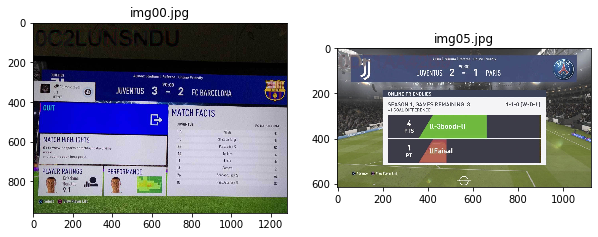

In [33]:
plt.figure(figsize=(10,5))
img = cv2.imread('data/img00.jpg')
img2 = cv2.imread('data/img05.jpg')
plt.subplot(1,2,1)
plt.title('img00.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.title('img05.jpg')
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

In [14]:
mask = np.zeros(img.shape)
mask.shape

(960, 1280, 3)

In [15]:
FF.fname.unique()

array(['img00.jpg', 'img01.jpg', 'img02.jpg', 'img03.jpg', 'img04.jpg',
       'img05.jpg', 'img06.jpg', 'img07.jpg', 'img08.jpg', 'img09.jpg'],
      dtype=object)

In [16]:
FF.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,bbox_x3,bbox_y3,bbox_x4,bbox_y4,labels,fname,img_type
0,47,239,1280,273,1280,418,38,377,1,img00.jpg,1
1,37,400,1280,428,1280,882,26,872,2,img00.jpg,1
2,353,109,3465,141,3489,481,345,481,1,img01.jpg,1
3,329,533,3493,521,3569,1633,317,1781,2,img01.jpg,1
4,121,673,3869,633,3909,1057,105,1117,1,img02.jpg,1


In [17]:
FF.to_csv('data_2.csv', index=False)

In [18]:
FF[FF.fname=='img00.jpg']

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,bbox_x3,bbox_y3,bbox_x4,bbox_y4,labels,fname,img_type
0,47,239,1280,273,1280,418,38,377,1,img00.jpg,1
1,37,400,1280,428,1280,882,26,872,2,img00.jpg,1


In [19]:
FF[FF['labels']==2][['bbox_x1','bbox_y1','bbox_x2','bbox_y2','bbox_x3','bbox_y3','bbox_x4','bbox_y4']].values[0].reshape(4,2)

array([[37, 400],
       [1280, 428],
       [1280, 882],
       [26, 872]], dtype=object)

In [20]:
data[data.fname=='img00.jpg'][data['class']==2].values[0][:-3]

/home/vasylcf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


array([37, 400, 677, 414, 676, 565, 28, 555], dtype=object)

/home/vasylcf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


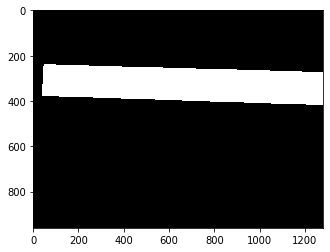

In [25]:
mask = np.zeros(img.shape)
pts= FF[FF.fname=='img00.jpg'][FF['labels']==1].values[0][:-3].astype('int').reshape(4,2)
mask = cv2.fillPoly(mask,[pts],color=(1,1,1))
plt.imshow(mask)

/home/vasylcf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


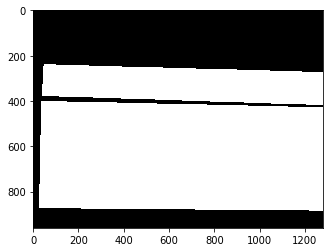

In [26]:
pts= FF[FF.fname=='img00.jpg'][FF['labels']==2].values[0][:-3].astype('int').reshape(4,2)
mask = cv2.fillPoly(mask,[pts],color=(1,1,1))
plt.imshow(mask)

/home/vasylcf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


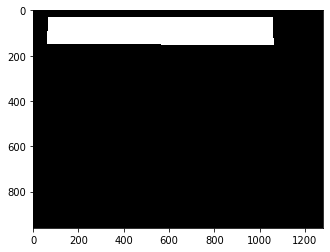

In [27]:
mask = np.zeros(img.shape)
pts= FF[FF.fname=='img05.jpg'][FF['labels']==1].values[0][:-3].astype('int').reshape(4,2)
mask = cv2.fillPoly(mask,[pts],color=(1,1,1))
plt.imshow(mask)

/home/vasylcf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


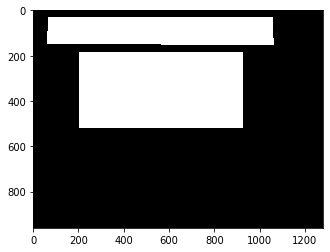

In [29]:
pts= FF[FF.fname=='img05.jpg'][FF['labels']==3].values[0][:-3].astype('int').reshape(4,2)
mask = cv2.fillPoly(mask,[pts],color=(1,1,1))
plt.imshow(mask)

In [34]:
for f in FF.fname.unique():
    img = cv2.imread('data_2/'+f)
    mask = np.zeros(img.shape)
    T = FF[FF.fname==f]
    for cl in T['labels']:
        pts = T[T['labels']==cl][['bbox_x1','bbox_y1','bbox_x2','bbox_y2','bbox_x3','bbox_y3','bbox_x4','bbox_y4']].values[0].reshape(4,2)
        pts = pts.astype('int')
        mask = cv2.fillPoly(mask,[pts],color=(cl,cl,cl))
    cv2.imwrite('annotations_2/'+f.split('.')[0]+'.png',mask)